# Plot Raw Map

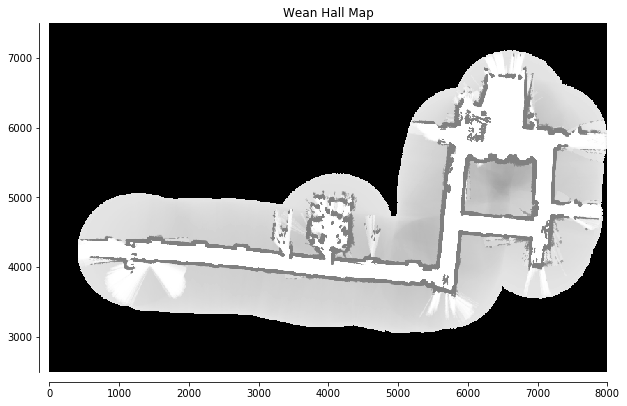

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import montecarlo_localization as mcl
%load_ext autoreload
%autoreload 2
%matplotlib inline

global_map = mcl.occupancy_map2('data/map/wean.dat.gz')

mcl.draw_map_state(global_map, rotate=True)



# Importing to numpy

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
gmap = np.genfromtxt("data/map/wean.dat.gz", delimiter=' ', skip_header=7)


In [3]:
gmap


array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

# slicing y: 650-730, x: 400-500

In [4]:
#pmat stands for portion of map
pmap = gmap[650:730, 400:500]




In [5]:
pmap

array([[0.757, 0.755, 0.752, ..., 0.482, 0.462, 0.455],
       [0.756, 0.757, 0.753, ..., 0.483, 0.473, 0.453],
       [0.76 , 0.757, 0.756, ..., 0.49 , 0.48 , 0.46 ],
       ...,
       [0.743, 0.738, 0.799, ..., 0.712, 0.709, 0.707],
       [0.743, 0.74 , 0.737, ..., 0.712, 0.71 , 0.707],
       [0.743, 0.741, 0.737, ..., 0.712, 0.71 , 0.709]])

# Plotting

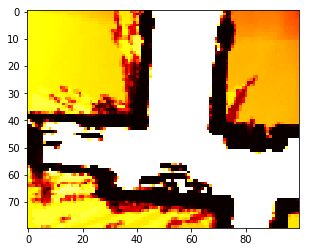

In [6]:

plt.imshow(pmap,cmap=plt.cm.hot)

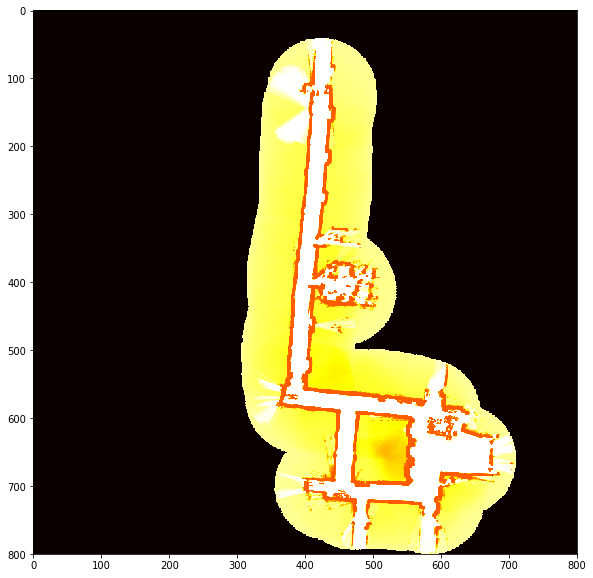

In [7]:
plt.figure(figsize = (10,10))
plt.imshow(gmap,cmap=plt.cm.hot,interpolation='none')

# Precompute Values

In [77]:
from line_algorithm import bresenham
import math

#format like this: x1,y1,x2,y2...

#set globals
MAX_X = 100
MAX_Y = 80
MAX_STEPS = 120
HI_SPACE_THRESHOLD = 0.9 # it's a empty sapce if higher than this value
LO_WALL_THRESHOLD = 0.2 # it's a wall (or barrier) if lower than this value


#distance formula
def get_distance(x1,y1,x2,y2):
    distance = ((x1-x2)**2 + (y1-y2)**2)**0.5
    return int(round(distance,0))

#bresenham algorithm
def get_points(x1,y1,x2,y2):
    line = bresenham([x1,y1],[x2,y2])
    return line
    
#determine the edge coordinates
def get_box_coord(alpha,x1,y1,side):
    #check the tangent-undefined values
    if alpha == math.pi/2:
        return x1, 0
    elif alpha == 2*math.pi/3:
        return x1, MAX_Y
    #sides 1, 2, 3, 4
    if side == 1:
        x = MAX_X
        y = y1 - ((MAX_X-x1)*math.tan(alpha))
        x = int(round(x,0))
        y = int(round(y,0))
        return x,y
    elif side == 2:
        y = 0
        x = x1 + ((MAX_Y-y1)/math.tan(alpha))
        x = int(round(x,0))
        y = int(round(y,0))
        return x,y
    elif side == 3:
        x = 0
        y = y1 - (-x1*math.tan(alpha))
        x = int(round(x,0))
        y = int(round(y,0))
        return x,y
    else:
        y = MAX_Y
        x = x1 + (-y1/math.tan(alpha))
        x = int(round(x,0))
        y = int(round(y,0))
        return x,y
def get_side(alpha,x1,y1,angles):
    #quadrants = get_corner_angles(x,y)
    #check which side will the angle end in
    if alpha > angles[0] and alpha <= angles[1]: # side2
        return 2
    elif alpha > angles[1] and alpha <= angles[2]: #side3
        return 3
    elif alpha > angles[2] and alpha <= angles[3]: #side4
        return 4
    else:
        return 1
    return

def get_corner_angles(x1,y1):
    #format, in quadrants: I, II, III,IV
    angles= []
    #quadrant I
    l,h = MAX_X - x1, MAX_Y - y1
    theta = math.atan(h/l)
    angles.append(theta)
    
    #quadrant II 
    l,h = -x1,MAX_Y - y1
    theta = math.atan(h/l) + math.pi
    angles.append(theta)
    
    #quadrant III
    l,h = -x1,-y1
    theta = math.atan(h/l) + math.pi
    angles.append(theta)
    
    #quadrant IV
    l,h = MAX_X - x1,-y1
    theta = math.atan(h/l) + 2*math.pi
    angles.append(theta)
    
    return angles

#main
#create a array that will store bin measures: 3-D, each 2D coordinate has 120 values
values = np.full((MAX_Y,MAX_X,MAX_STEPS),-1.0)
print("started to create the measured-range-bin")

"""
#print(get_box_coord(math.pi/2,55,59,2))
l = get_points(2,2,2,8)
print(l.path)
"""    

#for each x,y value
for x_coord in range(MAX_X):
    
    for y_coord in range(MAX_Y):
        #safeguard
        if x_coord == 0 or y_coord ==0 or x_coord == MAX_X-1 or y_coord== MAX_Y-1: continue
        
        #check if this point is worth calculating, cmv --> current map value
        cmv = pmap[y_coord,x_coord]
        
        if cmv <= HI_SPACE_THRESHOLD: continue
        
        corner_angles = get_corner_angles(x_coord,y_coord)
        
        for slope in range(MAX_STEPS):
            alpha = math.radians(slope*3)
            side = get_side(alpha,x_coord,y_coord, corner_angles)
            x2,y2 = get_box_coord(alpha,x_coord,y_coord,side)
            l = get_points(x_coord,y_coord,x2,y2)
            
            if l == None:
                continue
            
            #adjust the bresenham points here --> abp
            abp = l.path
            
            if abp[-1][0] == x_coord and abp[-1][1] == y_coord: abp = abp[::-1]
 


                


            
            for tuple_value in abp:
                if(tuple_value[0]>=MAX_X-1 or tuple_value[1] >= MAX_Y-1): continue


                pmap_value = pmap[tuple_value[1], tuple_value[0]]
                #if wall is hit calculate distance (point to wall)
                if pmap_value <= LO_WALL_THRESHOLD:
                    d = get_distance(x_coord,y_coord,tuple_value[0],tuple_value[1])
                    values[y_coord,x_coord,slope] = d
                    break
                #if never hit -->
                if tuple_value[0] == abp[-1][0] and tuple_value[1] == abp[-1][1]:
                    d = get_distance(x_coord,y_coord,tuple_value[0],tuple_value[1])
                    values[y_coord,x_coord,slope] = d
                    break

        
        
        

print("Finished to create the measured-range-bin")    



started to create the measured-range-bin
Finished to create the measured-range-bin


[(2, 8), (2, 7), (2, 6), (2, 5), (2, 4), (2, 3), (2, 2)]


# Plot the Range Measure Bin

<IPython.core.display.Javascript object>


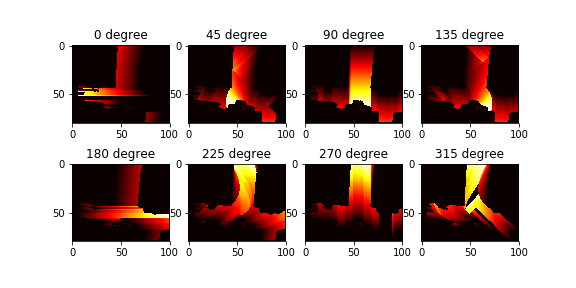

In [78]:

# show the range-estimation of 0, 45, 90, 135, 180, 225, 270, 315# show t 
# 3 degree per step. 
# id is 0, 15, 30, 45, 60, 75, 90, 105
#

%matplotlib notebook

plt.figure(figsize=(8, 4))


for i in range(8):
    thisStep = i*15
    plt.subplot(2,4,i+1)
    plt.imshow(values[:,:,thisStep],cmap=plt.cm.hot)
    plt.title(str(thisStep*3)+" degree")